### Decline Curve Analysis

Automatic decline curve fitting


### next step
https://github.com/shanminlin/decline_curve_analysis/blob/master/DCA.py
* flag 0 and na 
* initial peak
* calculate days-on

## 1. environment and functions

In [8]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from datetime import datetime
import calendar
from scipy.signal import find_peaks
pd.options.display.float_format = '{:.4f}'.format
# pptx
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE

In [13]:
def load_data(file_path, hc):
    """
    read, reformat, and clean data
    Arguments:
        file_path (string): data file location
        hc (string): oil or gas
    Returns:
        data (pd.DataFrame)
    
    """
    # Read in the monthly oil and gas data
    data = pd.read_csv(file_path)
    # date from year and month
    data.insert(1, 'date', data.apply(lambda row: datetime(int(row['year']), int(row['month']), 1), axis=1))
    # sort by date
    data = data.sort_values([col_id, 'date'], ascending=True)
    # index
    data = data.reset_index(drop=True)
    data.insert(0, 'Index', data.index)
    # number of days in the month
    data['no_days'] = data.apply(lambda row: calendar.monthlen(int(row['year']), int(row['month'])), axis=1)
    # mid month
    data['mid_month'] = data.apply(lambda row: row['date'] + pd.DateOffset(int(row['no_days']/2)), axis=1)
    # hc production daily rate
    data[hc + '_rate'] = data[hc] / data['no_days']
    return data

In [3]:
def decline_curve(dc_model, d_trans=0.06):
    """
    decline curve model
    Arguments:
        dc_model (str): name of the decline model 
        q_i (float): initial peak production rate
        d_i (float): initial decline rate
        b (float): b-factor, between 0 and 2
        d_f (float): decline rate when transition to exponenail decline
    """
    # exponential b = 0
    if dc_model == "exponential":
        def exponential_decline(x, q_i, d_i):
            return q_i * np.exp(- d_i * x)
        return exponential_decline
    # hyperbolic
    elif dc_model == "hyperbolic":
        def hyperbolic_decline(x, q_i, d_i, b):
            return q_i / np.power((1 + b * d_i * x), 1. / b)
        return hyperbolic_decline
    # harmonic b = 1
    elif dc_model == "harmonic":
        def harmonic_decline(x, q_i, d_i):
            return q_i / (1 + d_i * x)
        return parabolic_decline
    # hyperbolic to exponential
    elif dc_model == "hybrid":
        def hybrid_decline(x, q_i, d_i, b):
            # when transition occurs (t_trans)
            x_trans = (d_i / d_trans - 1) / (b * d_i)        
            # hyperbolic decline
            q_trans = q_i / np.power((1 + b * d_i * x_trans), 1. / b)
            q = q_i / np.power((1 + b * d_i * x), 1. / b)
            # switch to exponential decline
            q_exp = q_trans * np.exp(-d_trans * (x[x > x_trans] - x_trans))
            q[x > x_trans] = q_exp
            return q
        return hybrid_decline
    # exception
    else:
        print("I don't know this decline curve!")

In [4]:
# def dca(sub_data, col_hc, col_time, dc_model='hyperbolic', 
#         col_id='api', no_ignor=0, time_cutoff=12, min_record=6,
#         plot=True):
#     """
#     prepare data for production fitting
#     Arguments:
#         sub_data (pd.DataFrame): data
#         col_hc (string): column name of the HC of interest 
#         col_time (string): how many month since first prod
#         dc_model (string): DCA model to use
#         no_ignor (integer): number of initial records to be ingored
#         time_cutoff (float): range of records for identify initial peak
#         min_record (int): minimum records needed for dca analysis
#     Returns:
#         popt: fitted DCA parameters
#     """   
#     popt = None
#     sub_data = fur_clean(sub_data, col_hc, col_time)
#     if sub_data.shape[0] >= min_record:
#         # identify initial peak
#         peak_index = initial_peak(df=sub_data, col_hc=col_hc, no_ignor=no_ignor, time_cutoff=time_cutoff)
#         # initial peak vol
#         q_i = sub_data.loc[peak_index, col_hc].item()
#     #     # manually remove last phase
#     #     t_end = 70
#     #     sub_data.loc[sub_data['t'] > t_end, 't'] = -1
#         sub_data['t'] = sub_data[col_time] - sub_data.loc[peak_index, col_time]
#         # flag range of data used for dca fitting
#         flag_pred = sub_data['t'] >= 0    
#         if sum(flag_pred) >= min_record:
#             #Hyperbolic curve fit the data to get best fit equation
#             fun_decline = decline_curve(dc_model)
            
#             try:
#                 popt, _ = curve_fit(fun_decline, 
#                                     sub_data.loc[flag_pred, 't'], 
#                                     sub_data.loc[flag_pred, col_hc],
#                                     bounds=([q_i/1.1, 0.0, 0.0], [q_i*1.1, 1.0, 2.0]), 
#                                     method='trf',
#                                     loss='soft_l1' 
#                                     )
#                 flag_fit = True
# #                 print('Curve-fitted Variables: q_i='+str(int(popt[0])) \
# #                       +', b='+str(round(popt[1],3)) \
# #                       +', d_i='+str(round(popt[2],3)))
#             except RuntimeError:
#                 flag_fit = False
            
#             if flag_fit:
#                 # predicted production volume
#                 sub_data.loc[flag_pred, col_hc+'_pred'] = fun_decline(sub_data.loc[flag_pred, 't'], *popt)
# #                 # predict 20 years
# #                 t_max = 20*12
# #                 t_pred = np.linspace(start=0, stop=t_max, num=t_max+1) 
# #                 pred = fun_decline(t_pred, *popt)
# #                 # bring to same time scale
# #                 t_pred = t_pred + sub_data.loc[peak_index, col_time]

#             if plot & flag_fit:
#                 # overlay actual with fitted decline curve
#                 well = str(sub_data[col_id].unique()[0])
#                 fig, ax = plt.subplots(1, figsize=(15, 8))
#                 title = 'well: ' + well + ' ' + col_hc + ':'\
#                         + ' q_i ' + str(int(popt[0])) \
#                         + ', d_i ' + str(round(popt[2], 3))
#                 if dc_model == 'hyperbolic':
#                     title += ', b ' + str(round(popt[1], 3))
#                 ax.set_title(title, fontsize=20)
#                 label_size = 15
#                 yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
#                 xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
#                 ax.scatter(sub_data[col_time], sub_data[col_hc], color='grey', marker='.', alpha=0.8, s=50, linewidth=3)
#                 ax.scatter(sub_data.loc[flag_pred, col_time], sub_data.loc[flag_pred, col_hc], color='black', marker='.', alpha=0.8, s=50, linewidth=3, label="actual")
#                 ax.plot(sub_data[col_time], sub_data[col_hc], color='grey', linewidth=3, alpha=0.5, label='Actual')
#                 ax.plot(sub_data.loc[flag_pred, col_time], sub_data.loc[flag_pred, col_hc+'_pred'], color="red", linewidth=3, alpha=0.7, label="DCA fit")
#                 # ax.plot(T_pred, pred, color='b`lue', linewidth=3, alpha=0.5, label='DCA fit')
#                 ax.set_xlabel("Month", fontsize=20)
#                 ax.set_ylabel("Monthly Rate", fontsize=20)
#                 ax.legend()
#                 img_path = '../result/plt/' + well + '.png'
#                 fig.savefig(img_path)
#                 plt.close(fig)
                
#                 ## add fitting result to slide ##
#                 slide = prs.slides.add_slide(plot_slide_layout)
#                 # text paragraph
#                 # left = top = width = height = Inches(1)
#                 left = Inches(1)
#                 top = Inches(0.5)
#                 width = height = Inches(1)
#                 txBox = slide.shapes.add_textbox(left, top, width, height)
#                 tf = txBox.text_frame
#                 p = tf.add_paragraph()
#                 p.text = "well: " + well
#                 p.font.bold = True
#                 p.font.size = Pt(20)
#                 # plot
#                 top = Inches(1.7)
#                 left = Inches(0.5)
#                 height = Inches(5)
#                 width = Inches(8.5)
#                 pic = slide.shapes.add_picture(img_path, left, top, height=height, width=width)
#     return popt    

## 2. prepare data

In [5]:
def flag_missing_zero(sub_data, col_hc):
    """
    flag data with missing production or 0 production
    Arguments:
        sub_data (pd.DataFrame): data for a well
        col_hc (str): columna for hc of interest
    Returns:
        sub_data (pd.DataFrame): added 'flag_prod' column
    """
    sub_data['flag_pred'] = True
    # flag out missing or 0 production
    sub_data.loc[(sub_data[col_hc].isnull()) | (sub_data[col_hc]==0), 'flag_pred'] = False
    
    return sub_data


def flag_jump(sub_data, col_hc, min_record, ratio_cutoff=2.0, delta_days_cutoff=180):
    """
    flag data with big production decrease or big jump in days
    Arguments:
        sub_data (pd.DataFrame): data for a well
        col_hc (str): columna for hc of interest
        min_record (int): minimum of records to run dca
        ratio_cutoff (float): cutoff of ratio between first two production rates
        delta_days_cutoff (int): cutoff of delta days between first two production records
    Returns:
        sub_data (pd.DataFrame): with updated 'flag_prod' column
    """
    while sub_data['flag_pred'].sum() >= min_record:
        index_0, index_1 =sub_data.loc[sub_data['flag_pred'], 'Index'].tolist()[:2]
        hc_0, hc_1 = sub_data.loc[[index_0, index_1], col_hc]
        date_0, date_1 = sub_data.loc[[index_0, index_1], 'date']
        ratio = hc_0 / hc_1
        delta_days = (date_1 - date_0).days
        if (ratio > ratio_cutoff) | (delta_days > delta_days_cutoff):
            sub_data.loc[index_0, 'flag_pred'] = False
        else:
            break
    
    return sub_data


def identify_peak(sub_data, col_hc, time_cutoff=12, plot=False):
    """
    identify peak
    Arguments:
        sub_data (pd.DataFrame): data for a well
        col_hc (str): columna for hc of interest
        time_cutoff (int): number of records for identify peak
        plot (Boolean): whether to plot peak on production data
    Returns:
        index_peak (int): index of the peak
    """
    sub_data['flag_data'] = sub_data['flag_pred']
    # default to index of first row where flag_pred = True
    index_peak = sub_data.loc[sub_data['flag_pred'],:].iloc[0]['Index']
    # cutoff of heigh for peak identification
    height = sub_data.loc[sub_data['flag_pred'], col_hc].head(time_cutoff).quantile(0.75)
    peaks,_ = find_peaks(sub_data.loc[sub_data['flag_pred'], col_hc].head(time_cutoff), prominence=1, height=height) 
    list_peaks = []
    if len(peaks):
        for id_peak in list(peaks):
            index_peak = list(sub_data.loc[sub_data['flag_pred'], 'Index'])[id_peak]
            list_peaks.append(index_peak)
    # visualize the peak
    if plot:
        fig, ax = plt.subplots(1, figsize=(15, 8))
        title = 'peak identificatin'
        ax.set_title(title, fontsize=20)
        label_size = 15
        ax.scatter(sub_data.loc[sub_data['flag_pred'], 'date'], 
                   sub_data.loc[sub_data['flag_pred'], col_hc], 
                   color='grey', marker='.', alpha=0.8, s=50, label='data points')
        ax.scatter(sub_data.loc[list_peaks, 'date'], 
                   sub_data.loc[list_peaks, col_hc], 
                   color='blue', marker='.', alpha=0.8, s=50, label='intermediates')
        ax.scatter(sub_data.loc[index_peak, 'date'], 
                   sub_data.loc[index_peak, col_hc], 
                   color='red', marker='x', alpha=0.8, s=50, label='final peak')
        ax.plot(sub_data.loc[sub_data['flag_pred'], 'date'], 
                sub_data.loc[sub_data['flag_pred'], col_hc], 
                color='grey', linewidth=3, alpha=0.5)
        ax.set_xlabel("Date", fontsize=20)
        ax.set_ylabel("Daily Rate", fontsize=20)
        ax.legend() 
    
    return index_peak

def clean_data(sub_data, col_hc, min_record=12, plot=True):
    """
    prepare data for decline curve analysis
    Arguments:
        sub_data (pd.DataFrame): data for a well
        min_record (int): minimum of records to run dca
        col_hc (str): columna for hc of interest
        plot (Boolean): plot time-series with peak
    Returns:
        sub_data (pd.DataFrame): added 'flag_prod' column
        q_i (float): initial peak
    """
    q_i = np.nan
    # flag out missing or 0 production
    sub_data = flag_missing_zero(sub_data=sub_data, col_hc=col_hc)
    # flag data with big production decrease or big jump in days
    sub_data = flag_jump(sub_data=sub_data, col_hc=col_hc, min_record=min_record)
    if sub_data['flag_pred'].sum() >= min_record:
        # identify peak
        index_peak = identify_peak(sub_data=sub_data, col_hc=col_hc, plot=plot)
        q_i = sub_data.loc[index_peak, col_hc].item()
        # set flag_prod to False for record before index_peak
        sub_data.loc[sub_data['Index'] < index_peak, 'flag_pred'] = False
        # first reported production
        first_prod = sub_data.loc[index_peak, 'date']
        #sub_data['first_prod']= sub_data.loc[sub_data['flag_pred'],:].groupby('api')['date'].transform(min)
        # number of days_on
        sub_data['days_on'] = (sub_data['mid_month'] - first_prod).dt.days
        
    return q_i, sub_data 

In [6]:
## setting ##
col_id = 'api'
hc = 'oil'
col_hc = hc+'_rate'
single_phase = type(hc) is str
col_time = 'days_on'
file_data ='../data/eddy.csv'
dc_model = 'hyperbolic'
min_record = 12 # minimum of records to run dca

In [7]:
## data preparation ##
data = load_data(file_data, hc)

In [9]:
well = 3001522524
sub_data = data.loc[data[col_id] == well, :]

In [10]:
sub_data.head()

,Index,api,date,year,month,oil,gas,water,no_days,mid_month,oil_rate
1784,1784,3001522524,1981-02-01,1981,2,130311.0000,75035.0000,2766.0000,28,1981-02-15,4653.9643
1785,1785,3001522524,1994-01-01,1994,1,0.0000,0.0000,nan,31,1994-01-16,0.0000
1786,1786,3001522524,1994-02-01,1994,2,0.0000,0.0000,nan,28,1994-02-15,0.0000
1787,1787,3001522524,1994-03-01,1994,3,0.0000,0.0000,nan,31,1994-03-16,0.0000
1788,1788,3001522524,1994-04-01,1994,4,0.0000,0.0000,nan,30,1994-04-16,0.0000


In [11]:
q_i, sub_data = clean_data(sub_data, col_hc=col_hc, min_record=min_record, plot=False)

In [12]:
if sub_data['flag_pred'].sum() >= min_record:
    #Hyperbolic curve fit the data to get best fit equation
    fun_decline = decline_curve(dc_model)
#     # force to ignore last period
#     remove_tail = sub_data.loc[sub_data['flag_pred'], 'days_on'].max() - 10*365
#     sub_data.loc[sub_data['days_on'] > remove_tail, 'flag_pred']=False
    flag_pred = sub_data['flag_pred']

    try:
        popt, _ = curve_fit(fun_decline, 
                            sub_data.loc[flag_pred, col_time], 
                            sub_data.loc[flag_pred, col_hc],
                            bounds=([q_i/1.1, 0.0, 0.0], [q_i*1.1, 1.0, 2.0]), 
                            method='trf',
                            loss='soft_l1' 
                            )
        flag_fit = True
        print('Curve-fitted Variables: q_i='+str(int(popt[0])) \
              +', d_i='+str(round(popt[1],3)) \
              +', b ='+str(round(popt[2],3))
             )
    except RuntimeError:
        flag_fit = False
            

Curve-fitted Variables: q_i=40, d_i=0.022, b =1.745


In [14]:
if flag_fit:
    # predicted production volume

    sub_data.loc[flag_pred, col_hc+'_pred'] = fun_decline(sub_data.loc[flag_pred, col_time], *popt)
#     # predict 20 years
#     t_max = 20*12
#     t_pred = np.linspace(start=0, stop=t_max, num=t_max+1) 
#     pred = fun_decline(t_pred, *popt)
#     # bring to same time scale
#     t_pred = t_pred + sub_data.loc[peak_index, col_time]

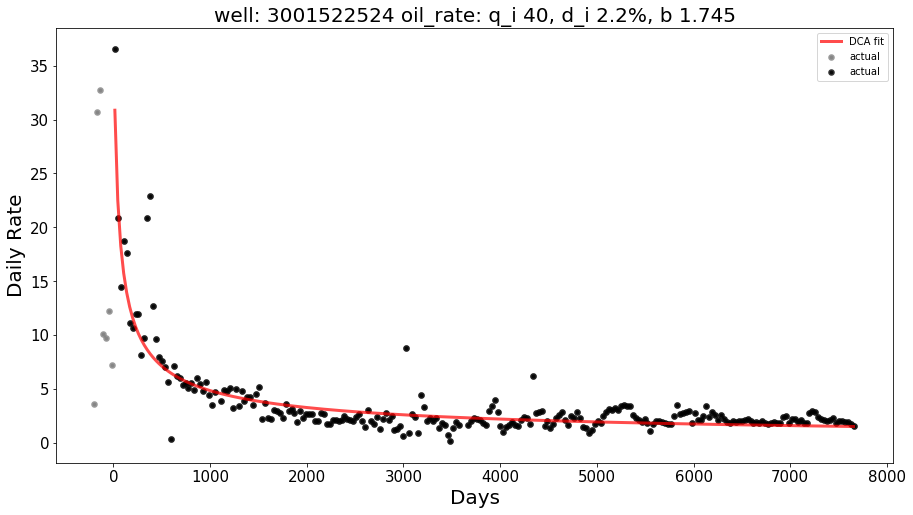

In [15]:
plot = True
if plot & flag_fit:
    # overlay actual with fitted decline curve
    well = str(well)
    fig, ax = plt.subplots(1, figsize=(15, 8))
    title = 'well: ' + well + ' ' + col_hc + ':'\
            + ' q_i ' + str(int(popt[0])) \
            + ', d_i ' + str(round(popt[1]*100, 1)) + '%'
    if dc_model == 'hyperbolic':
        title += ', b ' + str(round(popt[2], 3))
    ax.set_title(title, fontsize=20)
    label_size = 15
    yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
    xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
    ax.scatter(sub_data.loc[sub_data['flag_data'], col_time], 
               sub_data.loc[sub_data['flag_data'], col_hc], 
               color='grey', marker='.', alpha=0.8, s=50, linewidth=3, label="actual")
    ax.scatter(sub_data.loc[flag_pred, col_time], 
               sub_data.loc[flag_pred, col_hc], 
               color='black', marker='.', alpha=0.8, s=50, linewidth=3, label="actual")
    ax.plot(sub_data.loc[flag_pred, col_time], 
            sub_data.loc[flag_pred, col_hc+'_pred'], 
            color="red", linewidth=3, alpha=0.7, label="DCA fit")
    # ax.plot(T_pred, pred, color='b`lue', linewidth=3, alpha=0.5, label='DCA fit')
    ax.set_xlabel("Days", fontsize=20)
    ax.set_ylabel("Daily Rate", fontsize=20)
    ax.legend()
    # img_path = '../result/plt/' + well + '.png'
    # fig.savefig(img_path)
    # plt.close(fig)


In [16]:
## flag outlier based on ratio between dca predict and actual
# ratio = (predicted - actual over) / predicted 
sub_data.loc[flag_pred, 'delta_ratio'] = (sub_data.loc[flag_pred, col_hc+'_pred'] - sub_data.loc[flag_pred, col_hc]) / sub_data.loc[flag_pred, col_hc+'_pred']
# use mean +/- 2*std as cutoff for flagging outlier
ratio_mean = sub_data.loc[flag_pred, 'delta_ratio'].mean()
ratio_std = sub_data.loc[flag_pred, 'delta_ratio'].std()
cutoff_1 = ratio_mean - 2.0 * ratio_std
cutoff_2 = ratio_mean + 2.0 * ratio_std

In [17]:
# flag outlier
sub_data['flag_outlier'] = False
sub_data.loc[sub_data['delta_ratio'] < cutoff_1, 'flag_outlier'] = True
sub_data.loc[sub_data['delta_ratio'] > cutoff_2, 'flag_outlier'] = True

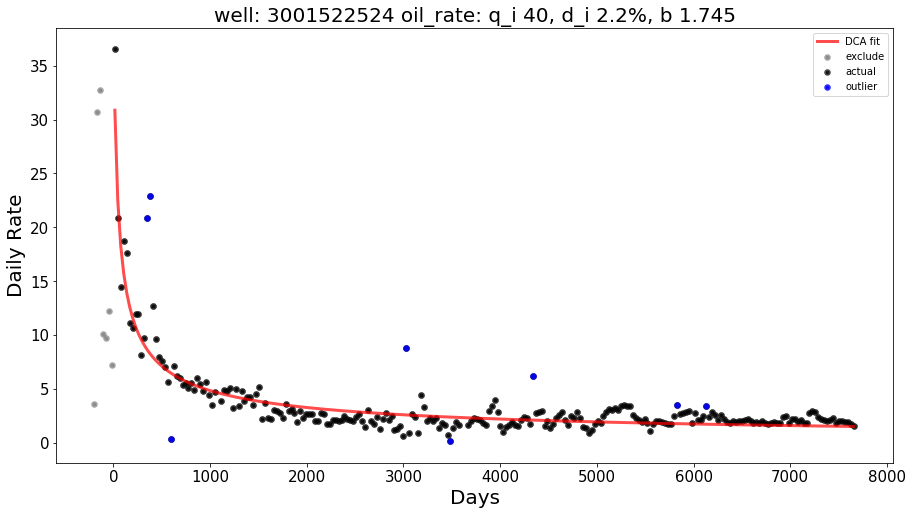

In [18]:
well = str(well)
fig, ax = plt.subplots(1, figsize=(15, 8))
title = 'well: ' + well + ' ' + col_hc + ':'\
        + ' q_i ' + str(int(popt[0])) \
        + ', d_i ' + str(round(popt[1]*100, 1)) + '%'
if dc_model == 'hyperbolic':
    title += ', b ' + str(round(popt[2], 3))
ax.set_title(title, fontsize=20)
label_size = 15
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
ax.scatter(sub_data.loc[sub_data['flag_data'], col_time], 
           sub_data.loc[sub_data['flag_data'], col_hc], 
           color='grey', marker='.', alpha=0.7, s=50, linewidth=3, label="exclude")
ax.scatter(sub_data.loc[flag_pred, col_time], 
           sub_data.loc[flag_pred, col_hc], 
           color='black', marker='.', alpha=0.7, s=50, linewidth=3, label="actual")
ax.scatter(sub_data.loc[sub_data['flag_outlier'], col_time], 
           sub_data.loc[sub_data['flag_outlier'], col_hc], 
           color='blue', marker='.', alpha=0.8, s=50, linewidth=3, label="outlier")
ax.plot(sub_data.loc[flag_pred, col_time], sub_data.loc[flag_pred, col_hc+'_pred'], color="red", linewidth=3, alpha=0.7, label="DCA fit")
# ax.plot(T_pred, pred, color='b`lue', linewidth=3, alpha=0.5, label='DCA fit')
ax.set_xlabel("Days", fontsize=20)
ax.set_ylabel("Daily Rate", fontsize=20)

ax.legend()


In [19]:
%%time

## DCA fitting wells and export fitting result to plots and ppt
# open presentation
prs = Presentation()
plot_slide_layout = prs.slide_layouts[6]
# placeholder for fitting output
dict_fit = {}

for well in id_list:
    sub_data = data.loc[data[col_id] == well, :]
    if single_phase:
        popt = dca(sub_data=sub_data, col_hc=col_hc, col_time=col_time, dc_model=dc_model)
        if popt is not None:
            dict_fit[well] = popt
    else:
        sub_oil, sub_gas = clean_data(sub_data, col_hc, col_id, col_time)
        # oil 
        popt_oil = dca(sub_data=sub_oil, col_hc='oil', col_time=col_time, dc_model=dc_model)
        # gas
        popt_gas = dca(sub_data=sub_gas, col_hc='gas', col_time=col_time, dc_model=dc_model)

# save ppt
prs.save('../result/'+col_hc+'.pptx')
# fitting output
df_fit = pd.DataFrame.from_dict(dict_fit, orient='index', columns=['q_i', 'd_i', 'b'])
df_fit.insert(0, col_id, df_fit.index)
df_fit.to_csv('../result/fit_'+col_hc+'.csv', index=False)

NameError: name 'id_list' is not defined

In [20]:
df_fit.describe()

NameError: name 'df_fit' is not defined